# Stratified random sampling from NDWI mosaic

## Load packages

In [13]:
%matplotlib inline

import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize


In [4]:
# define area name

area_name = 'Southern'

## Convert to one mosaic (only do it once)

In [19]:
# make tif

if not os.path.exists(f"NDWI_composite/{area_name.lower()}_NDWI_mosaic.tif"):
    os.chdir('NDWI_composite')
    os.system(f"gdalbuildvrt {area_name.lower()}_NDWI_mosaic.vrt {area_name.lower()}_NDWI_tile*.tif")
    os.system("gdal_translate "\
       "-co BIGTIFF=YES "\
       "-co COMPRESS=DEFLATE "\
       "-co ZLEVEL=9 "\
       "-co PREDICTOR=1 "\
       "-co TILED=YES "\
       "-co BLOCKXSIZE=1024 "\
       "-co BLOCKYSIZE=1024 "\
       +f"{area_name.lower()}_NDWI_mosaic.vrt "+ f"{area_name.lower()}_NDWI_mosaic.tif")
    os.chdir('../')

## Load NDWI mosaic and clip to AEZ (TODO: use AEZ-large_water_bodies)

In [20]:
if not os.path.exists(area_name): os.mkdir(area_name)

In [21]:
ds = xr.open_rasterio(f"NDWI_composite/{area_name.lower()}_NDWI_mosaic.tif").squeeze()

In [22]:
#load shapefile
#gdf = gpd.read_file(f'../../shapes/simplified_AEZs/{area_name}.shp')
gdf = gpd.read_file(f'../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_{area_name}.shp')

#rasterize shapeile
mask = xr_rasterize(gdf=gdf,
                     da=ds)

ds = ds.where(mask)
ds = ds.where(ds!=0)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Rasterizing to match xarray.DataArray dimensions (104514, 93681) and projection system/CRS (e.g. +init=epsg:6933)


In [23]:
dataset = ds.to_dataset(name='ndwi')

In [24]:

#ds.plot.imshow();

In [25]:
del mask

## Check NDWI distribution and determine thresholds

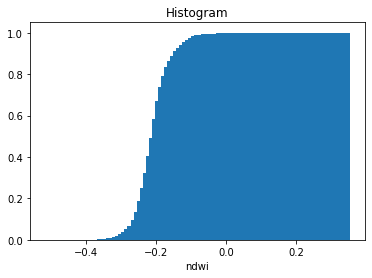

In [26]:
if not os.path.exists(f'{area_name}/ndwi_{area_name}.csv'):
    histy, histx, tmp = dataset.ndwi.plot.hist(bins=100, cumulative=True, density=True);
    np.savetxt(f'{area_name}/ndwi_{area_name}.csv', np.vstack((histx[1:], histy)).transpose(),fmt='%.3f', delimiter=',')

In [28]:
# use wofs
try:
    x, y = np.loadtxt(f'wofs_summary_aez/wofs_{area_name}.csv', delimiter=',', unpack=True)
except:
    x, y, t = np.loadtxt(f'wofs_summary_aez/wofs_{area_name}.csv', delimiter=',', unpack=True)
ephem = 0.1
perm = 0.9
perc = np.interp([ephem, perm], x, y)
print('percentile for ephemeral and permanent water', perc)
histx, histy = np.loadtxt(f'{area_name}/ndwi_{area_name}.csv', delimiter=',', unpack=True)
thresh = np.interp(perc, histy, histx)
print('Thresholds', thresh)

percentile for ephemeral and permanent water [0.991 0.998]
Thresholds [-0.073  0.04 ]


## Classify into dry, ephemeral and permanent

In [29]:
#threshold = {'Eastern': (-0.062, 0.03), 'Central': (-0.073, 0.04)
#             'Western': (-0.14, -0.035)
##            }
#low, high = threshold[area_name]

low, high = thresh[0], thresh[1]

label = np.zeros_like(dataset.ndwi.values, dtype=np.uint8)
label += (dataset.ndwi.values>=high).astype(np.uint8)*3
label += ((dataset.ndwi.values>=low) & (dataset.ndwi.values<high)).astype(np.uint8)*2
label +=(dataset.ndwi.values<low).astype(np.uint8)*1
dataset['label'] = ('y','x'), label
dataset['label'].attrs = dataset.ndwi.attrs

/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [30]:
# save classes

from datacube.utils.cog import write_cog

write_cog(dataset.label, f'{area_name}/{area_name}_label.tif')

PosixPath('Southern/Southern_label.tif')

## If the labels are alreay saved, read the labels

In [5]:
#
#data = xr.open_rasterio(f'{area_name}/{area_name}_label.tif').squeeze()
#dataset = data.to_dataset(name='label')

## plot classified ndwi

In [ ]:
#dataset.label.plot.imshow(figsize=(10,10));
#plt.savefig(f'{area_name}_ndwi_classes.png')

## sample from array

In [31]:
del ds

In [7]:
n_class= 3
class_sizes =[]
for class_id in np.arange(1, n_class+1):
    class_sizes.append((dataset.label==class_id).sum().values)

class_sizes = np.array(class_sizes)
print(class_sizes)
print(class_sizes/class_sizes.sum())

[5140926637   37256967    9159969]
[0.99105189 0.00718228 0.00176583]


In [15]:
n_sample = 500
n_sample_class = np.ceil(n_sample*1./ n_class).astype(int)
print(n_sample_class)

167


In [42]:
label_picked = {}
for class_id in np.arange(1, n_class+1):
    if class_sizes[class_id-1]> 1e9:
        # slightly over sample
        n_sample_over = np.ceil(n_sample_class*len(dataset.x)*len(dataset.y)/class_sizes[class_id-1]).astype(int)
        random_x = np.random.choice(np.arange(len(dataset.x)), n_sample_over, replace=False)
        random_y = np.random.choice(np.arange(len(dataset.y)), n_sample_over, replace=False)
        match = dataset.label.values[random_y, random_x] == class_id
        random_y, random_x = random_y[match], random_x[match]
        if len(random_y) < n_sample_class:
            print("Not enough points are picked, try increase the number of random points")
            break
        else:
            pick = np.random.choice(np.arange(len(random_y)), n_sample_class, replace=False)
            y, x = random_y[pick], random_x[pick]
    else:
        index = np.argwhere(dataset.label.values.flatten() == class_id).squeeze()
        picked = np.random.choice(index, n_sample_class, replace=False)
        # convert back to x, y 
        y, x  = np.unravel_index(picked, dataset.label.values.shape)
    label_picked[class_id] = (y, x)
    np.savetxt(f'{area_name}/{area_name}_class_{class_id}.csv', np.vstack((dataset.y[y].values, dataset.x[x].values)).transpose(),fmt='%d', delimiter=',')

In [43]:
for class_id in np.arange(1, n_class+1):
    #y, x = label_picked[class_id]
    #df = pd.DataFrame({'y': dataset.y[y].values, 'x':dataset.x[x].values})
    df = pd.read_csv(f'{area_name}/{area_name}_class_{class_id}.csv', header=None, names=['y','x'] )
    df['class']=class_id
    if class_id ==1: 
        dfs = df
    else: 
        dfs = dfs.append(df, ignore_index=True)

len(dfs)

501

In [44]:
gdf = gpd.GeoDataFrame(
        dfs,
        crs=dataset.label.crs,
        geometry=gpd.points_from_xy(dfs.x, dfs.y)).reset_index()

gdf = gdf.drop(['x', 'y'],axis=1)

gdf.to_file(f'{area_name}/{area_name}_samples.shp')